# 6. ONNX model deployment into ACI

<img src='https://github.com/retkowsky/images/blob/master/AzureMLservicebanniere.png?raw=true'>

## 1. Intro

In [27]:
import sys
print("Python version :",sys.version)

Python version : 3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31) 
[GCC 7.3.0]


In [28]:
import datetime
maintenant = datetime.datetime.now()
print(maintenant)

2020-09-16 12:59:14.952903


In [29]:
#Version
import azureml.core
print("Version Azure ML service :", azureml.core.VERSION)

Version Azure ML service : 1.13.0


In [30]:
import urllib.request
onnx_model_url = "https://www.cntk.ai/OnnxModels/mnist/opset_7/mnist.tar.gz"
urllib.request.urlretrieve(onnx_model_url, filename="mnist.tar.gz")

('mnist.tar.gz', <http.client.HTTPMessage at 0x7f2e551a0390>)

In [31]:
!tar xvzf mnist.tar.gz

mnist/
mnist/model.onnx
mnist/test_data_set_0/
mnist/test_data_set_0/input_0.pb
mnist/test_data_set_0/output_0.pb
mnist/test_data_set_1/
mnist/test_data_set_1/input_0.pb
mnist/test_data_set_1/output_0.pb
mnist/test_data_set_2/
mnist/test_data_set_2/input_0.pb
mnist/test_data_set_2/output_0.pb


## 2. Connection workspace Azure ML


In [32]:
from azureml.core import Workspace

ws = Workspace.from_config()
print(ws.name, ws.resource_group, ws.location, sep = '\n')

workshopAML2020
workshopAML2020-rg
westeurope


## 3. Référencement du modèle

In [33]:
model_dir = "mnist" # replace this with the location of your model files

# leave as is if it's in the same folder as this notebook

In [34]:
from azureml.core.model import Model

model = Model.register(workspace = ws,
                       model_path = model_dir + "/" + "model.onnx",
                       model_name = "mnist_model",
                       tags = {"Source": "Onnx"},
                       description = "MNIST image classification CNN from ONNX Model Zoo",)

Registering model mnist_model


In [35]:
# for images and plots in this notebook
import matplotlib.pyplot as plt  
from IPython.display import Image

# display images inline
%matplotlib inline

In [36]:
Image(url="http://3.bp.blogspot.com/_UpN7DfJA0j4/TJtUBWPk0SI/AAAAAAAAABY/oWPMtmqJn3k/s1600/mnist_originals.png", width=200, height=200)

## 4. Déploiement

We are now going to deploy our ONNX Model on AML with inference in ONNX Runtime. We begin by writing a score.py file, which will help us run the model in our Azure ML virtual machine (VM), and then specify our environment by writing a yml file. You will also notice that we import the onnxruntime library to do runtime inference on our ONNX models (passing in input and evaluating out model's predicted output). More information on the API and commands can be found in the [ONNX Runtime documentation](https://aka.ms/onnxruntime).

### 4.1 Write Score File

A score file is what tells our Azure cloud service what to do. After initializing our model using azureml.core.model, we start an ONNX Runtime inference session to evaluate the data passed in on our function calls.

In [37]:
%%writefile score.py
import json
import numpy as np
import onnxruntime
import sys
import os
import time


def init():
    global session, input_name, output_name
    # AZUREML_MODEL_DIR is an environment variable created during deployment.
    # It is the path to the model folder (./azureml-models/$MODEL_NAME/$VERSION)
    # For multiple models, it points to the folder containing all deployed models (./azureml-models)
    model = os.path.join(os.getenv('AZUREML_MODEL_DIR'), 'model.onnx')
    session = onnxruntime.InferenceSession(model, None)
    input_name = session.get_inputs()[0].name
    output_name = session.get_outputs()[0].name 
    

def preprocess(input_data_json):
    # convert the JSON data into the tensor input
    return np.array(json.loads(input_data_json)['data']).astype('float32')

def postprocess(result):
    # We use argmax to pick the highest confidence label
    return int(np.argmax(np.array(result).squeeze(), axis=0))
    
def run(input_data):

    try:
        # load in our data, convert to readable format
        data = preprocess(input_data)
        
        # start timer
        start = time.time()
        
        r = session.run([output_name], {input_name: data})
        
        #end timer
        end = time.time()
        
        result = postprocess(r)
        result_dict = {"result": result,
                      "time_in_sec": end - start}
    except Exception as e:
        result_dict = {"error": str(e)}
    
    return result_dict

def choose_class(result_prob):
    """We use argmax to determine the right label to choose from our output"""
    return int(np.argmax(result_prob, axis=0))

Overwriting score.py


### 4.2 Write Environment File

In [38]:
from azureml.core.conda_dependencies import CondaDependencies 

myenv = CondaDependencies.create(pip_packages=["numpy", "onnxruntime", "azureml-core", "azureml-defaults"])

with open("myenv.yml","w") as f:
    f.write(myenv.serialize_to_string())

### 4.3 Create Inference Configuration

In [39]:
from azureml.core.model import InferenceConfig
from azureml.core.environment import Environment


myenv = Environment.from_conda_specification(name="myenv", file_path="myenv.yml")
inference_config = InferenceConfig(entry_script="score.py", environment=myenv)

### 4.4 Deploy the model

In [42]:
from azureml.core.webservice import AciWebservice

aciconfig = AciWebservice.deploy_configuration(cpu_cores = 1, 
                                               memory_gb = 1, 
                                               tags = {'Source': 'onnx' , 'framework': 'Azure ML sdk' }, 
                                               description = 'ONNX for mnist model')

In [43]:
aci_service_name = 'exemple6-onnx-mnist'
print("Service =", aci_service_name)

Service = exemple6-onnx-mnist


In [44]:
%%time
aci_service = Model.deploy(ws, aci_service_name, [model], inference_config, aciconfig)
aci_service.wait_for_deployment(True)

Running...................................................
Succeeded
ACI service creation operation finished, operation "Succeeded"
CPU times: user 376 ms, sys: 78.1 ms, total: 454 ms
Wall time: 4min 36s


In [45]:
aci_service.wait_for_deployment(True)

SucceededACI service creation operation finished, operation "Succeeded"


In [46]:
if aci_service.state != 'Healthy':
    # run this command for debugging.
    print(aci_service.get_logs())

    # If your deployment fails, make sure to delete your aci_service or rename your service before trying again!
    # aci_service.delete()

In [47]:
print("Statut du modèle déployé :", aci_service.state)

Statut du modèle déployé : Healthy


In [48]:
print("Scoring endpoint ACI :", aci_service.scoring_uri)

Scoring endpoint ACI : http://1fb627e9-4d2c-462d-855b-9e39bf3c5bc9.westeurope.azurecontainer.io/score


## 5. Testing and Evaluation

### 5.1 Load Test Data

These are already in your directory from your ONNX model download (from the model zoo).

Notice that our Model Zoo files have a .pb extension. This is because they are [protobuf files (Protocol Buffers)](https://developers.google.com/protocol-buffers/docs/pythontutorial), so we need to read in our data through our ONNX TensorProto reader into a format we can work with, like numerical arrays.

In [49]:
import numpy as np 

import onnx
from onnx import numpy_helper

import json
import os

test_inputs = []
test_outputs = []

test_data_size = 3

for i in np.arange(test_data_size):
    input_test_data = os.path.join(model_dir, 'test_data_set_{0}'.format(i), 'input_0.pb')
    output_test_data = os.path.join(model_dir, 'test_data_set_{0}'.format(i), 'output_0.pb')
    
    # convert protobuf tensors to np arrays using the TensorProto reader from ONNX
    tensor = onnx.TensorProto()
    with open(input_test_data, 'rb') as f:
        tensor.ParseFromString(f.read())
    
    input_data = numpy_helper.to_array(tensor)
    test_inputs.append(input_data)
    
    with open(output_test_data, 'rb') as f:
        tensor.ParseFromString(f.read())
    
    output_data = numpy_helper.to_array(tensor)
    test_outputs.append(output_data)
    
if len(test_inputs) == test_data_size:
    print('Test data loaded successfully.')

Test data loaded successfully.


### 5.2 Show some sample images
We use `matplotlib` to plot 3 test images from the dataset.

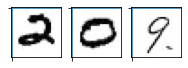

In [50]:
plt.figure(figsize = (16, 6))
for test_image in np.arange(3):
    plt.subplot(1, 15, test_image+1)
    plt.axhline('')
    plt.axvline('')
    plt.imshow(test_inputs[test_image].reshape(28, 28), cmap = plt.cm.Greys)
plt.show()

### 5.3 Run evaluation / prediction

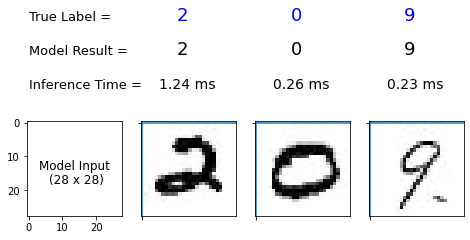

In [51]:
plt.figure(figsize = (16, 6), frameon=False)
plt.subplot(1, 8, 1)

plt.text(x = 0, y = -30, s = "True Label =", fontsize = 13, color = 'black')
plt.text(x = 0, y = -20, s = "Model Result =", fontsize = 13, color = 'black')
plt.text(x = 0, y = -10, s = "Inference Time =", fontsize = 13, color = 'black')
plt.text(x = 3, y = 14, s = "Model Input", fontsize = 12, color = 'black')
plt.text(x = 6, y = 18, s = "(28 x 28)", fontsize = 12, color = 'black')
plt.imshow(np.ones((28,28)), cmap=plt.cm.Greys)    


for i in np.arange(test_data_size):
    
    input_data = json.dumps({'data': test_inputs[i].tolist()})
    
    # predict using the deployed model
    r = aci_service.run(input_data)
    
    if "error" in r:
        print(r['error'])
        break
        
    result = r['result']
    time_ms = np.round(r['time_in_sec'] * 1000, 2)
    
    ground_truth = int(np.argmax(test_outputs[i]))
    
    # compare actual value vs. the predicted values:
    plt.subplot(1, 8, i+2)
    plt.axhline('')
    plt.axvline('')

    # use different color for misclassified sample
    font_color = 'red' if ground_truth != result else 'black'
    clr_map = plt.cm.gray if ground_truth != result else plt.cm.Greys

    # ground truth labels are in blue
    plt.text(x = 10, y = -30, s = ground_truth, fontsize = 18, color = 'blue')
    
    # predictions are in black if correct, red if incorrect
    plt.text(x = 10, y = -20, s = result, fontsize = 18, color = font_color)
    plt.text(x = 5, y = -10, s = str(time_ms) + ' ms', fontsize = 14, color = font_color)

    
    plt.imshow(test_inputs[i].reshape(28, 28), cmap = clr_map)

plt.show()

In [52]:
# Pour supprimer le service
aci_service.delete()

<img src="https://github.com/retkowsky/images/blob/master/Powered-by-MS-Azure-logo-v2.png?raw=true" height="300" width="300">